In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.plotting as bplt

from pylab import rcParams

from functools import reduce, lru_cache

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, push_notebook
from bokeh.layouts import widgetbox, column
from bokeh.models import CustomJS, ColumnDataSource
from bokeh.models.widgets import Slider
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact
%matplotlib inline
bplt.output_notebook()

Loading BokehJS ...

# Fused lasso法で累帯構造の不連続変化点を検出する

1. データセット読み込み
1. 解析粒子を切り出し
1. fused lasso 

Fused lasso: データ数とパラメータ数が等しい. 隣り合うパラメータの差が小さくなるようにフィッティングを行う. 

$$
    argmin\left[ \sum^N_{i=1}\left(y_i - \beta_i \right)^2 + \lambda \sum^{N-1}_{i=1}\left( \left|\beta_{j+1} - \beta_j\right| \right) \right]
$$

このような正則化項の場合, 回帰の目的関数はステップ関数を想定することになる.

1次関数が連結したような折れ線グラフへの回帰を行うには, 例えば正則化項を

$$
    \lambda\sum\left|\frac{1}{2} \left(\beta_{j+1} + \beta_{j-1}\right) - \beta_j \right|
$$

とすればよい

### 参考

- [genlasso document](../../../ドキュメント/Articles/Machine_learning/genlasso_documents.pdf)

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R

library(genlasso)
library(dplyr)
library(tidyr)
library(broom)
library(purrr)

# 所与のデータ(ys)に関数(func)を適用しつつ, データysそのものを返す関数
tee <- function(ys,func){
    func(ys)
    return (ys)
}

aply <- function(d,func){
    return (func(d))
}

# 斑晶の組成プロファイルに対するfused lassoの適用

To detencting abrupt change of chemical profile, 
Applying fused lasso method to chemical profile of Cr in orthopyroxene phenocryst in HMA lava in the SVB.

Fused lassoをそのまま使うことは, ステップ関数の復元には適しているが, 組成プロファイルのようにシグナルが位置や時間の関数になっている場合には適していない.

L1正則化項を隣り合うパラメータの変化率に変えることで, 

## データセット

Onedrive/My_log/htmls/data/SVB/mineral/EPMA/opx_zoning_compile.csv

- 複数の斑晶の組成プロファイルが収められている.
- それぞれのプロファイルは"comment"列の内容で区別される.
- 中心からの半径は"radius"行を参照

In [4]:
%%R 
df <- read.csv("../data/SVB/mineral/EPMA/opx_zoning_compile.csv")
commentList <- df$comment %>% unique

df %>%
    subset(comment == "1002-9-1C-1_Line1") %>%
    .$Cr2O3 -> y

df %>% 
    subset(comment == "1002-9-1C-1_Line1") %>% 
    .$radius -> radius


In [5]:
%R -o commentList

print(commentList)

[1] 1002-9-1A-4_Line1           1002-9-1C-1_Line1          

[3] 1002-9-1D-2_Line1           2013_0815_1002-9-1C-OpxOl-1

[5] 2013_0815_1002-9-1C-OpxOl-2 1002-9-1D-2                

[7] 1002-9-1D-Opx8-1            1002-9-1D-Opx8-2           

8 Levels: 1002-9-1A-4_Line1 1002-9-1C-1_Line1 ... 2013_0815_1002-9-1C-OpxOl-2



## 1002-9-1C-1_Line1 のCrプロファイルへの適用

In [6]:



def callback(x=0.):
    %R -o y
    %R -o radius
    %R -i x
    %R newbeta <- y %>% fusedlasso1d %>% coef(lambda=x)
    %R newbeta <- newbeta$beta
    %R -o newbeta

    fig = plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)
    ax.set_title("$\lambda$ = "+str(x),fontsize=20)
    ax.set_xlabel("radius",fontsize=20)
    ax.set_ylabel("Cr2O3", fontsize=20)
    ax.plot(list(radius),list(y),"o", c="black")
    ax.plot(list(radius),list(newbeta))

    

_=interact(callback, x=(0,1, 0.01))

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, step=0.01), Output()), _dom_classes=('w…

## トレンドフィルター

例えば, 複数の直線が連結したものとしてプロファイルにフィッティング

```r
trandfilter(y, ord = 1) # ord = order of polynominal function
```

In [8]:



def callback(x=0):
    %R -o y
    %R -o radius
    %R -i x
    %R newbeta <- y %>% trendfilter(ord=1) %>% coef(lambda=x)
    %R newbeta <- newbeta$beta
    %R -o newbeta

    fig = plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)
    ax.set_title("$\lambda$ = "+str(x),fontsize=20)
    ax.set_xlabel("radius",fontsize=20)
    ax.set_ylabel("Cr2O3", fontsize=20)
    ax.plot(list(radius),list(y),"o", c="black")
    ax.plot(list(radius),list(newbeta))

    

interact(callback, x=(0,0.1, 0.01))

interactive(children=(FloatSlider(value=0.0, description='x', max=0.1, step=0.01), Output()), _dom_classes=('w…

<function __main__.callback>

### Cross validation

(k-fold cross validation)

0. $\lambda$をある値に設定する
1. データを$k$組に分ける.
2. $k-1$組のデータに対してLASSOを適用
3. 得られたモデルで残った1組のデータ値を予測し, 実際の値との予測誤差を計算
4. 1～3を繰り返し, 予測誤差の平均と標準誤差を求める

1 standerd error rileの場合, 予測誤差の平均が, 最小の予測誤差の1 s.e. 区間に収まる$\lambda$のうち, 最大の$\lambda$を結果として返す.


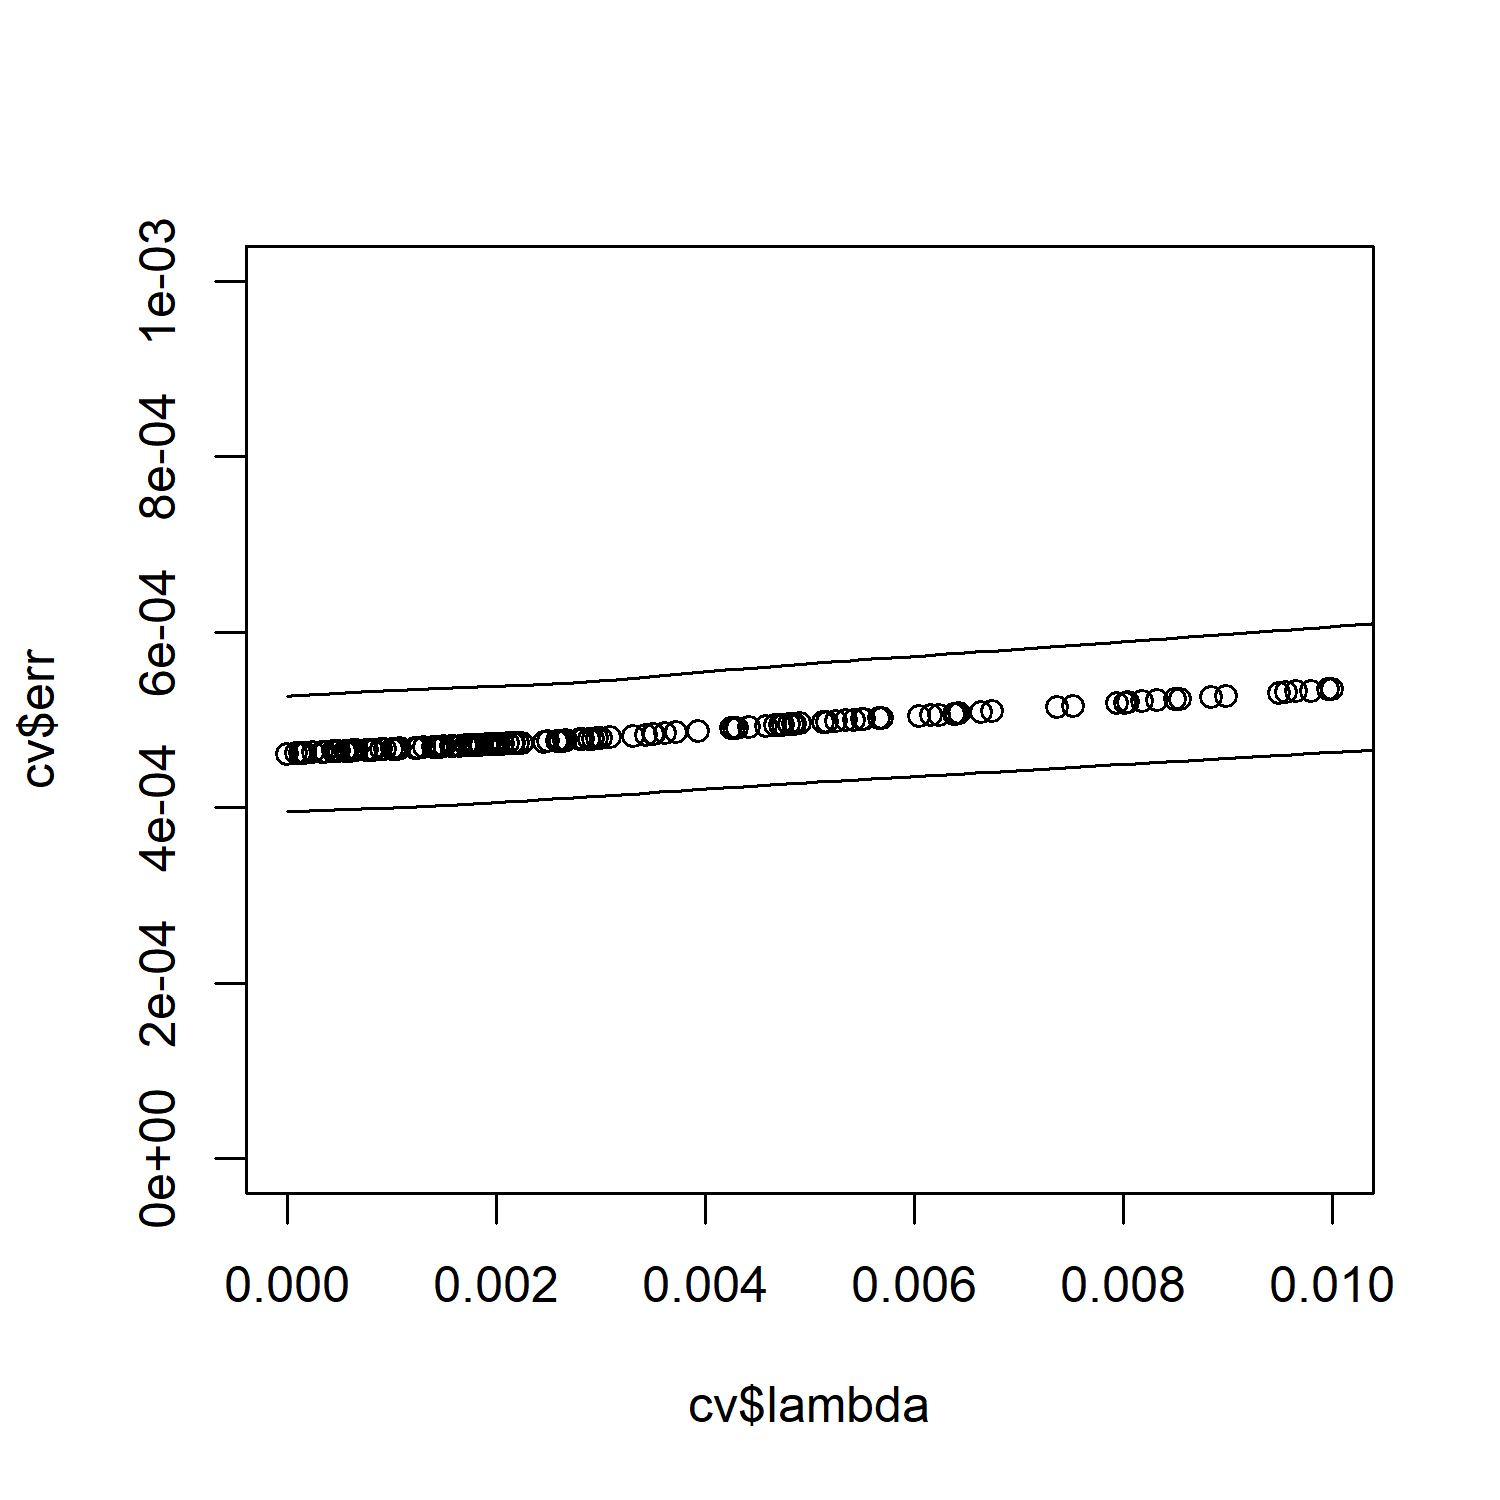

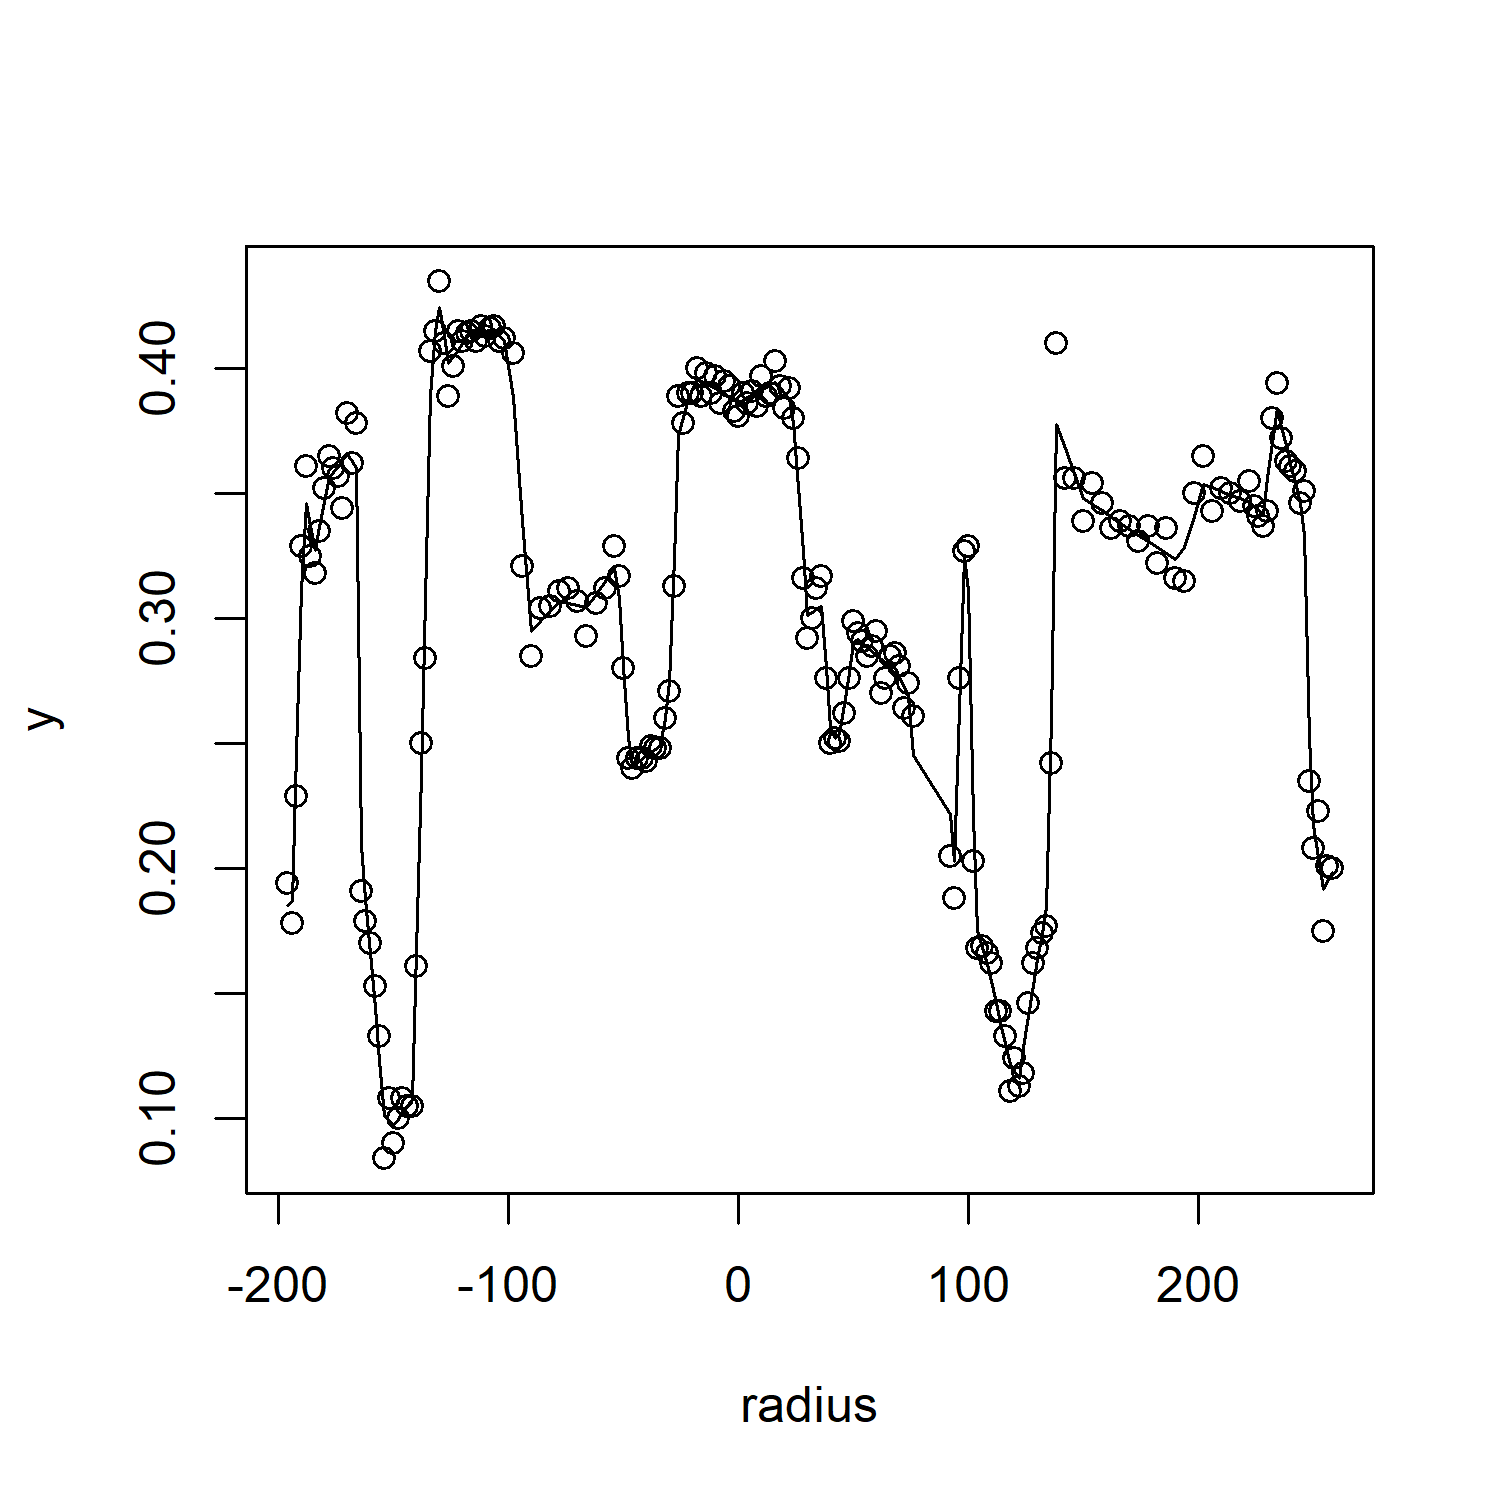

In [42]:
%%R -w 5 -h 5 -u in -r 300

df %>%
    subset(comment == "1002-9-1C-1_Line1") %>%
    .$Cr2O3 -> y

df %>% 
    subset(comment == "1002-9-1C-1_Line1") %>% 
    .$radius -> radius

y %>%
    trendfilter(ord=1) %>%
    cv.trendfilter(k=4) %>%
    aply(function(cv){
        print(cv$lambda.1se)
        plot(cv$lambda,cv$err, xlim=c(0,0.01),ylim=c(0,0.001))
        maxerr <- cv$err[1]+cv$se[1]
        lines(list(0,10),list(maxerr,maxerr))
        lines(cv$lambda,cv$err+cv$se)
        lines(cv$lambda,cv$err-cv$se)
        
        y %>%
            trendfilter(ord=1) %>%
            coef(lambda=cv$lambda.1se) %>%
            tee(function(coef){
                print(coef)
                plot(radius, y)
                lines(radius, coef$beta)
            }) %>% .$beta -> beta
        return(list(beta=beta,lambda=cv$lambda.1se))
            #plot(,x=radius, lambda=cv$lambda.1se) %>%
            #invisible
    }) -> result


In [32]:
%R -o result
%R -o y
%R -o radius

print(result[1])
#print("Optimized λ: "+str(result[1]))

p = figure(plot_width=800, plot_height=600)
p.circle(list(radius),list(y))
p.line(list(radius),list(result[0]))
show(p)

[1] 0.008843367

